In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [3]:
def llaveSort(cuadro):
    if cuadro != ".DS_Store":
        return int(cuadro.replace(".jpg",""))
    else:
        return -1

data_entrenamiento = []

directorio = os.listdir("./k_resize")
directorio.sort(key=llaveSort)

for cuadro in directorio:
    if cuadro != ".DS_Store":
        x = cv.imread(os.path.join("./k_post",cuadro))/255
        y = cv.imread(os.path.join("./k_resize",cuadro))/255
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        data_entrenamiento.append([x,y])

train_dataset = tf.data.Dataset.from_tensor_slices(data_entrenamiento)
for input_image, real_image in train_dataset:
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

test_dataset = train_dataset.take(20)

In [4]:
import random
random.shuffle(data_entrenamiento)

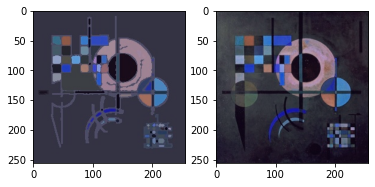

(256, 256, 3)


In [43]:
m=random.choice(range(0,len(data_entrenamiento)-1))
inp = data_entrenamiento[m][0]
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(data_entrenamiento[m][0])
f.add_subplot(1,2, 2)
plt.imshow(data_entrenamiento[m][1])
plt.show(block=True)
print(inp.shape)

In [6]:
lr = 0.0008
NUM_EPOCHS = 2
BATCH_SIZE = 2
VALID_RATIO = 10
OUTPUT_CHANNELS = 3

In [7]:
def convolucion(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [8]:
def deconvolucion(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [9]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    convolucion(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    convolucion(128, 4),  # (bs, 64, 64, 128)
    convolucion(256, 4),  # (bs, 32, 32, 256)
    convolucion(512, 4),  # (bs, 16, 16, 512)
    convolucion(512, 4),  # (bs, 8, 8, 512)
    convolucion(512, 4),  # (bs, 4, 4, 512)
    convolucion(512, 4),  # (bs, 2, 2, 512)
    convolucion(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    deconvolucion(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    deconvolucion(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    deconvolucion(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    deconvolucion(512, 4),  # (bs, 16, 16, 1024)
    deconvolucion(256, 4),  # (bs, 32, 32, 512)
    deconvolucion(128, 4),  # (bs, 64, 64, 256)
    deconvolucion(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
generator = Generator()

In [11]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [13]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = convolucion(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = convolucion(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = convolucion(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [14]:
discriminator = Discriminator()

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


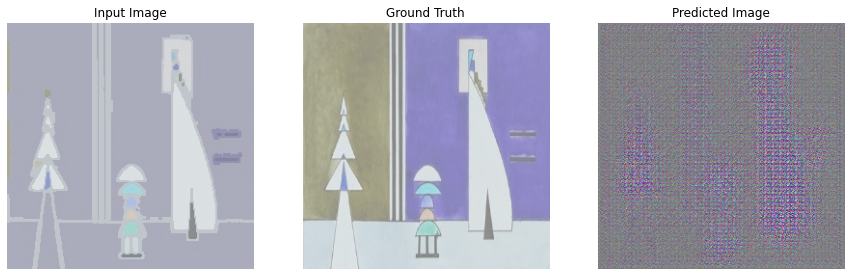

In [19]:
for example_input, example_target in train_dataset.take(1):
    generate_images(generator, tf.expand_dims(example_input, 0), tf.expand_dims(example_target, 0))

In [20]:
EPOCHS = 150

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [21]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [22]:
import time
from IPython import display

def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, tf.expand_dims(example_input, 0), tf.expand_dims(example_target,0))
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(tf.expand_dims(input_image, 0), tf.expand_dims(target,0), epoch)
    print()

    # saving (checkpoint) the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

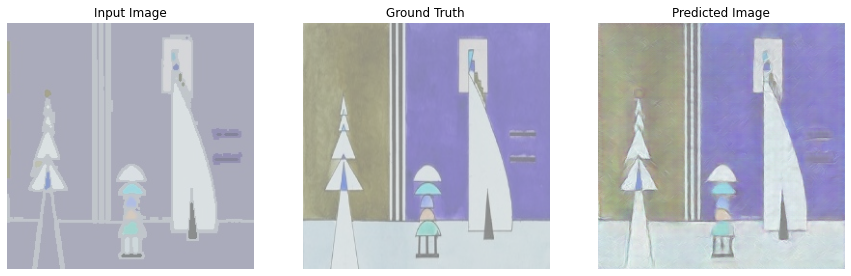

Epoch:  99
....................................................................................................
....................................................................................................
....................................................................................................
............
Time taken for epoch 100 is 307.4056260585785 sec



In [71]:
fit(train_dataset, 100, test_dataset)

In [26]:
tf.keras.models.save_model(generator,'./modelos/modelo24',save_format = 'h5',include_optimizer=True)

In [23]:
checkpoint.restore('./training_checkpoints/ckpt-24')

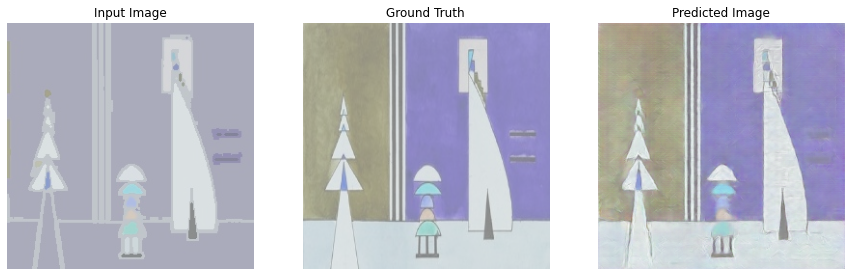

In [25]:
for example_input, example_target in train_dataset.take(1):
    generate_images(generator, tf.expand_dims(example_input, 0), tf.expand_dims(example_target, 0))

In [95]:
import csv

with open('./paleta_rgb.csv') as f:
    paleta=[tuple(int(num) for num in line) for line in csv.reader(f)]

print(paleta[0])

(77, 55, 47)


In [29]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________